# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [ ]:
#!mkdir -p /data/tusimple
#!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
#!unzip train_set.zip -d /data/tusimple  #

In [ ]:
#from google.colab import drive

#drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
#cd gdrive/MyDrive/data

/content/gdrive/MyDrive/data


In [ ]:
#!unzip train_set.zip -d tusimple

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [2]:
import sys
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
import cv2
import argparse
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [8]:
import os

path = '/content/MyDrive'
for file in os.listdir(path):
    if '.json' in file:
        with open(f'{path}/{file}') as f:
            print(file, len(f.readlines()))

FileNotFoundError: ignored

- label_data_0313.json 2858 for training
- label_data_0531.json 358 for validating
- label_data_0601.json 410 for testing

In [4]:
DEFAULT_SIZE = (512, 256)
import torch


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, val=False, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.train = train
        self.val = val # val
        self.size = size
        self.images_list = []
        self.lanes_list = []

        json_files = []
        if train:
            json_files.append(f'{dataset_path}/label_data_0313.json')
        if val:
            json_files.append(f'{dataset_path}/label_data_0531.json')
        else:
            json_files.append(f'{dataset_path}/label_data_0601.json')

        for json_file in json_files:
            with open(json_file) as f:
                for line in f:
                    data = json.loads(line)
                    self.images_list.append(data['raw_file'])
                    xy_list = []
                    for lane in data['lanes']:
                        xy = np.hstack((np.array([lane]).T, np.array([data['h_samples']]).T))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                    self.lanes_list.append(xy_list)

    def get_image(self, idx):
        img_path = f'{self.dataset_path}/{self.images_list[idx]}'
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        shape = img.shape
        mean_values = np.array([103.939, 116.779, 123.68]).astype(np.float32)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.float32) - mean_values
        return torch.from_numpy(np.transpose(img, (2, 0, 1))).float() / 255, shape
    
    def get_train_item(self, idx):
        image, (h, w, c) = self.get_image(idx)
        binary_tensor = np.zeros((h, w), dtype=np.uint8)
        instance_tensor = np.zeros((h, w), dtype=np.uint8)

        lanes = self.lanes_list[idx]
        for i, lane in enumerate(lanes):
            cv2.polylines(binary_tensor, [lane], False, 1, 10)
            cv2.polylines(instance_tensor, [lane], False, i + 1, 10)

        binary_tensor = cv2.resize(binary_tensor, self.size, interpolation=cv2.INTER_NEAREST)  
        instance_tensor = cv2.resize(instance_tensor, self.size, interpolation=cv2.INTER_NEAREST)

        binary_tensor = torch.from_numpy(binary_tensor).long()
        instance_tensor = torch.from_numpy(instance_tensor).long()
        return {
            'input_tensor': image, 
            'binary_tensor': binary_tensor, 
            'instance_tensor': instance_tensor,
            'raw_file': self.images_list[idx]
        }
    
    def get_test_item(self, idx):
        image, _ = self.get_image(idx)
        path = '/'.join(self.images_list[idx].split('/')[-3:])
        return {
            'input_tensor': image, 
            'raw_file': self.images_list[idx], 
            'path': path
        }

    def __getitem__(self, idx):
        # TODO
        return  self.get_train_item(idx) if self.train or self.val else self.get_test_item(idx)
    
    def __len__(self):
        # TODO
        return len(self.images_list)

## data visulization

In [5]:
train_set = LaneDataset(path)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0)

FileNotFoundError: ignored

In [ ]:
batch = next(iter(train_loader))
batch['input_tensor'].shape # batch_size * channel * DEFAULT_SIZE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


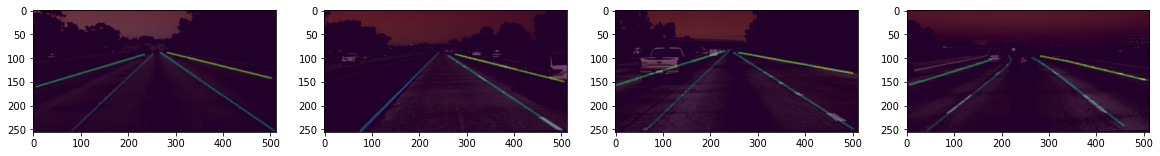

In [ ]:
inputs = batch['input_tensor']
labels_bin = batch['binary_tensor']
labels_inst = batch['instance_tensor']

plt.figure(figsize=(20, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(inputs[i].permute(1, 2, 0))
    plt.imshow(labels_inst[i], alpha=0.5)
plt.show()

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

reference: https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation

In [ ]:
#!git clone https://github.com/iArunava/ENet-Real-Time-Semantic-Segmentation.git

In [ ]:
import sys

sys.path.append('./ENet-Real-Time-Semantic-Segmentation/models/')

In [ ]:
from InitialBlock import InitialBlock
from RDDNeck import RDDNeck
from UBNeck import UBNeck
from ASNeck import ASNeck

In [ ]:
import torch
import torch.nn as nn

class ENet_encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        # The initial block
        self.init = InitialBlock()
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)

    def forward(self, x):
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)

        return x, i1, i2

class ENet_decoder(nn.Module):
    def __init__(self, nclass, **kwargs):
        super().__init__()
        # The fourth bottleneck
        self.C = nclass
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)

    def forward(self, x, i1, i2):
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        return x

class ENet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ENet_encoder()
        self.decoder_logit = ENet_decoder(2)
        self.decoder_embed = ENet_decoder(5)
        
    def forward(self, x):
        x, i1, i2 = self.encoder.forward(x)

        logit = self.decoder_logit(x, i1, i2)
        embedding = self.decoder_embed(x, i1, i2)

        return embedding, logit


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [ ]:
import torch
import torch.nn.functional as F

def discriminative_loss_single(embedding, inst_label, delta_v, delta_d, param_var, param_dist, param_reg):
    c, h, w = embedding.size()
    device = 'cuda' if inst_label.is_cuda else 'cpu'

    num_classes = len(torch.unique(inst_label)) - 1
    h, w = inst_label.shape
    inst_masks = torch.zeros(num_classes, h, w).byte().to(device)

    for idx, label in enumerate(torch.unique(inst_label)):
        if label:
            inst_masks[idx - 1] = inst_label == label

    embeddings = []
    for i in range(num_classes):
        feature = torch.transpose(torch.masked_select(embedding, inst_masks[i, :, :]).view(c, -1), 0, 1)
        embeddings.append(feature)

    centers = []
    for feature in embeddings:
        center = torch.mean(feature, dim=0, keepdim=True)
        centers.append(center)

    loss_var = torch.Tensor([0.0]).to(device)
    for feature, center in zip(embeddings, centers):
        dis = torch.norm(feature - center, 2, dim=1) - delta_v
        dis = F.relu(dis)
        loss_var += torch.mean(dis)
    loss_var /= num_classes

    if num_classes == 1:
        return loss_var, loss_var, torch.zeros(1)

    centers = torch.cat(centers, dim=0)
    A = centers.repeat(1, num_classes).view(-1, c)
    B = centers.repeat(num_classes, 1)
    distance = torch.norm(A - B, 2, dim=1).view(num_classes, num_classes)

    eye = torch.eye(num_classes).to(device)
    pair_distance = torch.masked_select(distance, eye == 0)

    pair_distance = delta_d - pair_distance
    pair_distance = F.relu(pair_distance)
    loss_dist = torch.mean(pair_distance).view(-1)

    loss_reg = torch.mean(torch.norm(centers, 2, dim=1)).view(-1)

    loss = param_var * loss_var + param_dist * loss_dist + param_reg * loss_reg
    return loss, loss_var, loss_dist, loss_reg


def discriminative_loss(embedding_batch, label_batch,
                        delta_v=0.5,
                        delta_d=1.5,
                        param_var=1.0,
                        param_dist=1.0,
                        param_reg=0.001):
    loss, loss_v, loss_d, loss_r = 0, 0, 0, 0
    for embedding, inst_lbl in zip(embedding_batch, label_batch):
        _loss, _loss_v, _loss_d, _loss_r = \
            discriminative_loss_single(embedding, inst_lbl, delta_v, delta_d, param_var, param_dist, param_reg)

        loss += _loss
        loss_v += _loss_v
        loss_d += _loss_d
        loss_r += _loss_r

    return loss, loss_v, loss_d, loss_r

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [ ]:
batch_size = 16
num_workers = 0

train_set = LaneDataset(path)
val_set = LaneDataset(path, train=False, val=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataloaders = {'train': train_loader, 'val': val_loader}

In [ ]:
num_train = len(train_set)
num_val = len(val_set)
print(f"num_train: {num_train}, num_val: {num_val}")

num_train: 3268, num_val: 358


In [ ]:
def init_weights(model):
    if type(model) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
        torch.nn.init.xavier_uniform_(model.weight)
        if model.bias is not None:
            model.bias.data.fill_(0.01)

net = ENet()
net.to(device)

params_to_update = net.parameters()
optimizer = optim.Adam(params_to_update)
MSELoss = nn.MSELoss()
net.apply(init_weights)

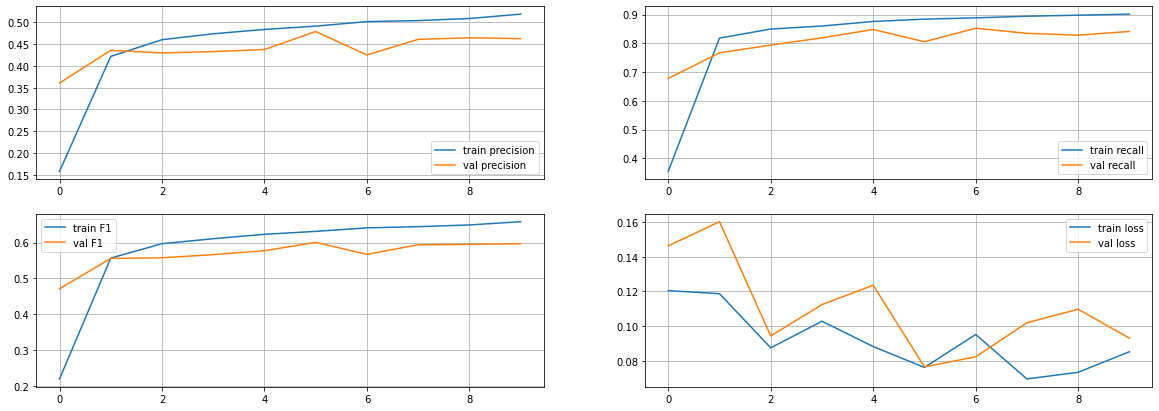

In [ ]:
from matplotlib.widgets import RectangleSelector
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from IPython import display
import warnings
warnings.simplefilter("ignore", UserWarning)

train_log = {'precision': [], 'recall': [], 'F1': [], 'loss': []}
val_log = {'precision': [], 'recall': [], 'F1': [], 'loss': []}


for epoch in range(10):
    print("Epoch:", epoch)
    TP, FP, FN = 0, 0, 0
    net.eval()
    print("training")
    for idx, batch in enumerate(tqdm(dataloaders['train'])):
        inputs = batch['input_tensor'].to(device)
        labels_bin = batch['binary_tensor'].to(device)
        labels_inst = batch['instance_tensor'].to(device)

        optimizer.zero_grad()

        #forward pass
        embeddings, logit = net(inputs)
        
        preds_bin = torch.argmax(logit, dim=1, keepdim=True)
        preds_bin_expand = preds_bin.view(-1)
        labels_bin_expand = labels_bin.view(-1)

        bin_count = torch.bincount(labels_bin_expand)
        bin_prop = bin_count.float() / torch.sum(bin_count)
        weight_bin = torch.tensor(1) / (bin_prop + 0.2)

        CrossEntropyLoss = nn.CrossEntropyLoss(weight=weight_bin)
        loss_bin = CrossEntropyLoss(logit, labels_bin)

        loss_disc, loss_v, loss_d, loss_r = discriminative_loss(embeddings,
                                                                labels_inst,
                                                                delta_v=0.2,
                                                                delta_d=1,
                                                                param_var=.5,
                                                                param_dist=.5,
                                                                param_reg=0.001)
        loss = loss_bin + loss_disc * 0.01

        loss.backward()
        optimizer.step()
        
        # TP, FN, FP
        _, fp, fn, tp = confusion_matrix(labels_bin_expand.detach().cpu(), 
                                          preds_bin_expand.detach().cpu()).ravel()
        TP += tp
        FN += fn
        FP += fp

        precision = TP/(TP + FP + 1e-6)
        recall = TP/(TP + FN + 1e-6)
        f1_score = 2 * precision * recall / (precision + recall + 1e-6)

        if idx % 50 == 0:
            print(f"after {idx} step: precision: {precision} recall: {recall} f1: {f1_score} loss: {loss.item()} ")

    # metrics
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)
    train_log['precision'].append(precision)
    train_log['recall'].append(recall)
    train_log['F1'].append(f1_score)
    train_log['loss'].append(loss.item())

    # Eval
    TP, FP, FN = 0, 0, 0
    net.eval()
    print("validating")
    for idx, batch in enumerate(tqdm(dataloaders['val'])):
        inputs = batch['input_tensor'].to(device)
        labels_bin = batch['binary_tensor'].to(device)
        labels_inst = batch['instance_tensor'].to(device)

        with torch.no_grad():
            embeddings, logit = net(inputs)
        
            preds_bin = torch.argmax(logit, dim=1, keepdim=True)
            preds_bin_expand = preds_bin.view(-1)
            labels_bin_expand = labels_bin.view(-1)

            bin_count = torch.bincount(labels_bin_expand)
            bin_prop = bin_count.float() / torch.sum(bin_count)
            weight_bin = torch.tensor(1) / (bin_prop + 0.2)

            CrossEntropyLoss = nn.CrossEntropyLoss(weight=weight_bin)
            loss_bin = CrossEntropyLoss(logit, labels_bin)

            loss_disc, loss_v, loss_d, loss_r = discriminative_loss(embeddings,
                                                                    labels_inst,
                                                                    delta_v=0.2,
                                                                    delta_d=1,
                                                                    param_var=.5,
                                                                    param_dist=.5,
                                                                    param_reg=0.001)
            loss = loss_bin + loss_disc * 0.01

        # TP, FN, FP
        _, fp, fn, tp = confusion_matrix(labels_bin_expand.detach().cpu(), 
                                          preds_bin_expand.detach().cpu()).ravel()
        TP += tp
        FN += fn
        FP += fp

        precision = TP/(TP + FP + 1e-6)
        recall = TP/(TP + FN + 1e-6)
        f1_score = 2 * precision * recall / (precision + recall + 1e-6)

        if idx % 50 == 0:
            print(f"after {idx} step: precision: {precision} recall: {recall} f1: {f1_score} loss: {loss.item()} ")

    # metrics
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = 2 * precision * recall / (precision + recall)
    val_log['precision'].append(precision)
    val_log['recall'].append(recall)
    val_log['F1'].append(f1_score)
    val_log['loss'].append(loss.item())

    model_path = f"enet_0919_epoch-{epoch}.pt"
    torch.save(net, model_path)

    # plot:
    display.clear_output()
    plt.figure(figsize=(20, 7))
    for i, key in enumerate(train_log.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(train_log[key], label=f"train {key}")
        plt.plot(val_log[key], label=f"val {key}")
        plt.grid()
        plt.legend()
    plt.show()

In [ ]:
#with open(f"train_log_0919.json", "w") as outfile:
#    json.dump(train_log, outfile)
#with open(f"val_log_0919.json", "w") as outfile:
#    json.dump(val_log, outfile)

We can find that after 5 epoch, the val loss increase, it refers to overfit.

In [ ]:
PATH = 'enet_0919_epoch-5.pt'
if device == 'cuda':
    model = torch.load(PATH)
else:
    model = torch.load(PATH, map_location=torch.device('cpu') )

In [ ]:
batch = next(iter(dataloaders['train']))

In [ ]:
with torch.no_grad():
    embs, logit = model(batch['input_tensor'].to(device))
logits = torch.argmax(logit, dim=1, keepdim=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


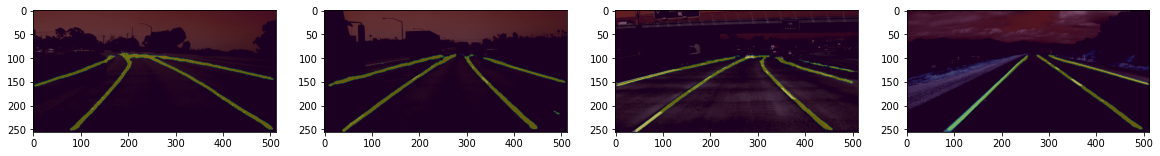

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(batch['input_tensor'][i].permute(1, 2, 0))
    plt.imshow(logits[i][0].detach().cpu().numpy(), alpha=0.4)

## Homography Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
HNET_DEFAULT_SIZE = (128, 64)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=HNET_DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.train = train
        self.size = size
        self.images_list = []
        self.lanes_list = []

        json_files = []
        if train:
            json_files.append(f'{dataset_path}/label_data_0313.json')
            json_files.append(f'{dataset_path}/label_data_0531.json')
        else:
            json_files.append(f'{dataset_path}/label_data_0601.json')

        for json_file in json_files:
            with open(json_file) as f:
                for line in f:
                    data = json.loads(line)
                    self.images_list.append(data['raw_file'])
                    xy_list = []
                    for lane in data['lanes']:
                        xy = np.hstack((np.array([lane]).T, np.array([data['h_samples']]).T))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                    self.lanes_list.append(xy_list)

    def __getitem__(self, idx):
        # TODO
        img_path = f'{self.dataset_path}/{self.images_list[idx]}'
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        h, w, _ = img.shape
        w2, h2 = self.size
        #mean_values = np.array([103.939, 116.779, 123.68]).astype(np.float32)
        img = cv2.resize(img, self.size, interpolation=cv2.INTER_LINEAR)
        img = img.astype(np.float32) #- mean_values
        image = torch.from_numpy(np.transpose(img, (2, 0, 1))).float() / 255
        ground_truth_trajectory = [torch.from_numpy(
            np.hstack((arr * np.array([w2/w, h2/h]), np.ones((len(arr), 1)))).astype(np.float32)
        )
                                   for arr in self.lanes_list[idx]]
        return image, ground_truth_trajectory
    
    def __len__(self):
        # TODO
        return len(self.images_list)

In [ ]:
homo_dataset = HomographyPredictionDataset('./tusimple')

To further understand the lane fitting part, I apply the lane fitting process on the ground true x, y coordinates.

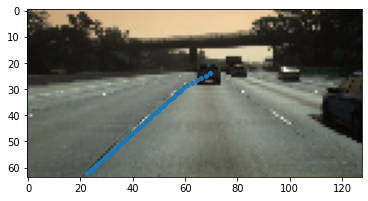

In [ ]:
img, gts = homo_dataset[20]
plt.imshow(img.permute(1, 2, 0))
i = 0
plt.scatter(gts[i][:, 0], gts[i][:, 1], s=15)

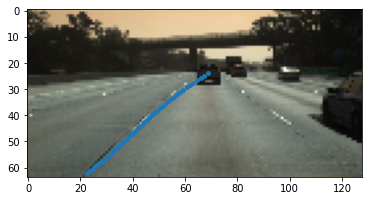

In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
H = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

# P' = HP
P = gts[i]
pts_projects = torch.matmul(H, P.T)

# Y = [y^3, y^2, y, 1] 3rd order polynomial.
Y = pts_projects[1, :]
#Y = mapping_y(P, pts_projects[1, :])
Y_One = torch.ones(Y.size())
Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()

# w = (YTY)−1YTx'
X = pts_projects[0, :]
w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
                                  Y_stack.t()),
                     X.view(-1, 1))

x_preds = torch.matmul(Y_stack, w)
preds = torch.stack((x_preds.squeeze(), Y, pts_projects[2, :]), dim=1).t()
transformation_back = torch.matmul(torch.inverse(H), preds)
x_back = transformation_back[0]

plt.imshow(img.permute(1, 2, 0))
plt.scatter(x_back, gts[i][:, 1], s=15)

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [ ]:
from matplotlib import pyplot as plt
import cv2

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [ ]:
image = cv2.resize(image, (128, 64))

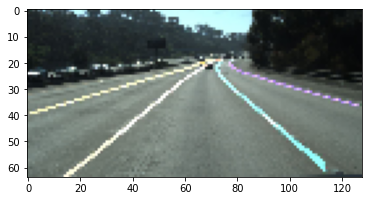

In [ ]:
plt.imshow(image)

In [ ]:
R_np = R.numpy()

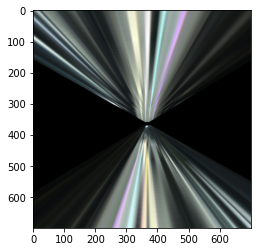

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

## H-Net

![image.png](attachment:image.png)

In [ ]:
class consecutiveBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pad=1, norm_layer=nn.BatchNorm2d, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=pad, bias=False)
        self.bn1 = norm_layer(out_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=pad, bias=False)
        self.bn2 = norm_layer(out_channels)
        self.relu2 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return self.maxpool(x)

In [ ]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
        self.block1 = consecutiveBlock(in_channels=3, out_channels=16)
        self.block2 = consecutiveBlock(in_channels=16, out_channels=32)
        self.block3 = consecutiveBlock(in_channels=32, out_channels=64)
        
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(8192, 1024)
        self.bn = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, 6)


    def forward(self, x):
        # TODO
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [ ]:
class HNetLoss(torch.nn.modules.loss._Loss):
    def __init__(self, gt_pts, transformation_coefficient):
        super(HNetLoss, self).__init__()
        self.gt_pts = gt_pts
        self.transformation_coefficient = transformation_coefficient
    
    def _hnet_loss(self):
        self.transformation_coefficient = torch.cat((self.transformation_coefficient, 
                                                     torch.tensor([1.0]).to(device)),
                                                    dim=0)
        H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8]).to(device)
        H_shape = 9
        H = torch.zeros(H_shape).to(device)
        H.scatter_(dim=0, index=H_indices, src=self.transformation_coefficient)
        H = H.view((3, 3))
        
        P = self.gt_pts
        pts_projects = torch.matmul(H, P.T)
        
        # Y = [y^3, y^2, y, 1] 3rd order polynomial.
        Y = pts_projects[1, :]
        Y_One = torch.ones(Y.size()).to(device)
        Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()
        
        # w = (YTY)−1YTx'
        X = pts_projects[0, :]
        w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
                                      Y_stack.t()),
                         X.view(-1, 1))
        x_preds = torch.matmul(Y_stack, w)
        preds = torch.stack((x_preds.squeeze(), Y, pts_projects[2, :]), dim=1).t()
        
        # P'_hat = H-1P_hat
        transformation_back = torch.matmul(torch.inverse(H), preds)
        x_back = transformation_back[0]
        loss = torch.mean(torch.pow(self.gt_pts.t()[0, :] - x_back, 2))
        return loss

    def forward(self):
        return self._hnet_loss()

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
log = {'train_loss': [], 'val_loss': []}

hnet = HNet()
hnet.to(device)
optimizer = torch.optim.AdamW(hnet.parameters(), lr=5e-5)

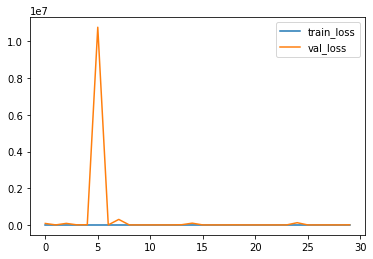

In [ ]:
from tqdm.notebook import tqdm
from IPython import display

batch_size = 32
for epoch in range(30):
    print("Epoch:", epoch)
    print('Training')
    train_homo_dataset = HomographyPredictionDataset('./tusimple')
    val_homo_dataset = HomographyPredictionDataset('./tusimple', train=False)
    train_step, val_step = len(train_homo_dataset), len(val_homo_dataset)
    train_homo_dataset = iter(train_homo_dataset)
    val_homo_dataset = iter(val_homo_dataset)
    
    hnet.train()
    for step in tqdm(range(train_step//batch_size)):
        # get batch
        gts = []
        for i in range(batch_size):
            in_, gt = next(train_homo_dataset)
            in_ = in_.unsqueeze(0)
            inputs = in_ if i == 0 else torch.vstack((inputs, in_))
            gts.append(gt)

        optimizer.zero_grad()
        # forward pass
        outs = hnet(inputs.to(device))

        # calculate loss
        i = 0
        for out, gt_list in zip(outs, gts):
            for gt in gt_list:
                if len(gt) > 1:
                    hloss = HNetLoss(gt.to(device), out)
                    if i == 0:
                        loss = hloss()
                    else:
                        loss += hloss()

        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(f"After {step} step: loss: {loss.item()}")
    
    log['train_loss'].append(loss.item())
    
    print("Validating")
    hnet.eval()
    for step in tqdm(range(val_step//batch_size)):
        # get batch
        gts = []
        for i in range(batch_size):
            in_, gt = next(val_homo_dataset)
            in_ = in_.unsqueeze(0)
            inputs = in_ if i == 0 else torch.vstack((inputs, in_))
            gts.append(gt)

        with torch.no_grad():
            outs = hnet(inputs.to(device))

        # calculate loss
        i = 0
        for out, gt_list in zip(outs, gts):
            for gt in gt_list:
                if len(gt) > 1:
                    hloss = HNetLoss(gt.to(device), out)
                    if i == 0:
                        loss = hloss()
                    else:
                        loss += hloss()
        
        if step % 10 == 0:
            print(f"After {step} step: loss: {loss.item()}")
    
    log['val_loss'].append(loss.item())
    
    model_path = f"hnet_0919_epoch-{epoch}.pt"
    torch.save(hnet, model_path)
    
    # plot
    display.clear_output()
    plt.plot(log['train_loss'], label='train_loss')
    plt.plot(log['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [ ]:
np.argmin(log['val_loss'])

15

After training the HNet, we can find that in epoch 15, we get the minimize loss on validating set.

In [ ]:
class prepareImage(torch.utils.data.Dataset):
    def __init__(self, dataset_path, size1=DEFAULT_SIZE, size2=HNET_DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.size1 = size1
        self.size2 = size2
        self.images_list = []
        json_files = []
        json_files.append(f'{dataset_path}/label_data_0601.json')

        for json_file in json_files:
            with open(json_file) as f:
                for line in f:
                    data = json.loads(line)
                    self.images_list.append(data['raw_file'])

    def get_image(self, idx):
        img_path = f'{self.dataset_path}/{self.images_list[idx]}'
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        shape = img.shape
        mean_values = np.array([103.939, 116.779, 123.68]).astype(np.float32)
        img1 = cv2.resize(img, self.size1, interpolation=cv2.INTER_LINEAR)
        img1 = img1.astype(np.float32) - mean_values
        img1 = torch.from_numpy(np.transpose(img1, (2, 0, 1))).float() / 255
        
        img2 = cv2.resize(img, self.size2, interpolation=cv2.INTER_LINEAR)
        img2 = img2.astype(np.float32) - mean_values
        img2 = torch.from_numpy(np.transpose(img2, (2, 0, 1))).float() / 255
        return img1, img2, img, 
    
    def get_image_item(self, idx):
        image1, image2, img = self.get_image(idx)

        return {
            'input_tensor1': image1, 
            'input_tensor2': image2,
            'origin': img,
        }
    

    def __getitem__(self, idx):
        # TODO
        return self.get_image_item(idx)
    
    def __len__(self):
        # TODO
        return len(self.images_list)

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
enet_model = torch.load('enet_0919_epoch-5.pt')
hnet_model = torch.load('hnet_0919_epoch-15.pt')

In [ ]:
data = prepareImage(path)
data_loader = DataLoader(data, batch_size=1, shuffle=True, num_workers=0)
temp = iter(data_loader)

In [ ]:
class LaneDetector:
    def __init__(self, hnet, lanenet):
        self.enet_model = lanenet
        self.hnet_model = hnet
    
    def get_H_mat(self, transformation_coefficient):
        transformation_coefficient = torch.cat((transformation_coefficient, 
                                                torch.tensor([1.0]).to(device)), dim=0)
        H_indices = torch.tensor([0, 1, 2, 4, 5, 7, 8]).to(device)
        H_shape = 9
        H = torch.zeros(H_shape).to(device)
        H.scatter_(dim=0, index=H_indices, src=transformation_coefficient)
        H = H.view((3, 3))
        return H

    def get_H_batch(self, h_outs):
        H_batch = [self.get_H_mat(H).detach().cpu() for H in h_outs]
        return H_batch
    
    def get_transform_back(self, H, gt):
        # P' = HP
        P = gt
        pts_projects = torch.matmul(H, P.T)

        # Y = [y^3, y^2, y, 1] 3rd order polynomial.
        Y = pts_projects[1, :]
        Y_One = torch.ones(Y.size())
        Y_stack = torch.stack((torch.pow(Y, 3), torch.pow(Y, 2), Y, Y_One), dim=1).squeeze()

        # w = (YTY)−1YTx'
        X = pts_projects[0, :]
        w = torch.matmul(torch.matmul(torch.inverse(torch.matmul(Y_stack.t(), Y_stack)),
                                          Y_stack.t()),
                             X.view(-1, 1))

        x_preds = torch.matmul(Y_stack, w)
        preds = torch.stack((x_preds.squeeze(), Y, pts_projects[2, :]), dim=1).t()
        transformation_back = torch.matmul(torch.inverse(H), preds)
        x_back = transformation_back[0]

        return x_back
    
    def cluster_embed(self, embeddings, preds_bin, band_width):
        c = embeddings.shape[1]
        n, _, h, w = preds_bin.shape
        preds_bin = preds_bin.view(n, h, w)
        preds_inst = torch.zeros_like(preds_bin)
        for idx, (embedding, bin_pred) in enumerate(zip(embeddings, preds_bin)):
            embedding_fg = torch.transpose(torch.masked_select(embedding, bin_pred.byte()).view(c, -1), 0, 1)
            clustering = DBSCAN(eps=0.35, min_samples=5).fit(embedding_fg.cpu().detach().numpy())
            preds_inst[idx][bin_pred.byte()] = torch.from_numpy(clustering.labels_).cuda() + 1
        return preds_inst
    
    def get_Y_batch(self, pred_insts):
        Y_batch = []
        for i, pred_inst in enumerate(pred_insts):
            lanes = []
            cls_of_lane = pred_inst.unique().detach().cpu().tolist()
            for cls in cls_of_lane:
                if cls:
                    Y_ = torch.nonzero(pred_inst == cls)[:, [1, 0]] * 64/256
                    Y_one_ = torch.ones((len(Y_), 1)).to(device)
                    Y_stack_ = torch.hstack((Y_, Y_one_))
                    lanes.append(Y_stack_.detach().cpu())
            Y_batch.append(lanes)
        return Y_batch
    
    def __call__(self, batch):
        imgs = batch['input_tensor1'].to(device)
        imgs2 = batch['input_tensor2'].to(device)
        origin_imgs = [cv2.resize(img.numpy(), (128, 64))[...,::-1] for img in batch['origin']]
        
        with torch.no_grad():
            embeddings, logit = self.enet_model(imgs)
        pred_bin_batch = torch.argmax(logit, dim=1, keepdim=True)
        pred_insts = self.cluster_embed(embeddings, pred_bin_batch, band_width=0.5)
        print(pred_insts.shape)
        Y_batch = self.get_Y_batch(pred_insts)
        
        with torch.no_grad():
            h_outs = self.hnet_model(imgs2)

        H_batch = self.get_H_batch(h_outs)
        
        num_of_img = len(origin_imgs)
        for i in range(num_of_img):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.title('LaneNet output')
            plt.imshow(origin_imgs[i])
            for Y in Y_batch[i]:
                plt.scatter(Y[:, 0], Y[:, 1], s=1)
            
            plt.subplot(1, 2, 2)
            plt.title('After Hnet lane fitting')
            plt.imshow(origin_imgs[i])
            for Y in Y_batch[i]:
                x_back = get_transform_back(H_batch[i], Y)
                mask = x_back <= 128
                plt.scatter(x_back[mask], Y[:, 1][mask], s=1)
            
            plt.show()

In [ ]:
batch = next(temp)

If two lanes are clustered into the same cluster, it will let the Hnet lane fitting fail.

torch.Size([1, 256, 512])


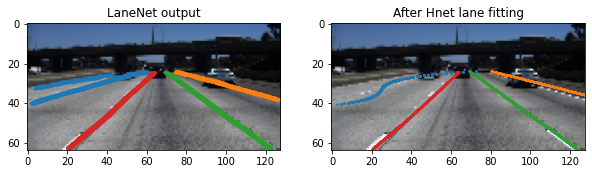

In [ ]:
detector = LaneDetector(hnet=hnet_model, lanenet=enet_model)
detector(batch)